# Проект - Отток клиентов.

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

**Описание данных**

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). 

**Признаки**

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата

**Целевой признак**

Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

### Cчитываем данные из файла и сохраняем их в переменную df, получаем общую информацию о датафрейме методом info() и выводим первые 5 строк датафрейма, с помощью посторения гистограм получаем инфоормацию о распределении данных в столбцах.

In [2]:
#df = pd.read_csv('D:\Мои Документы\Desktop\Материалы по учебе\Обучение с учителем\Churn.csv')
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


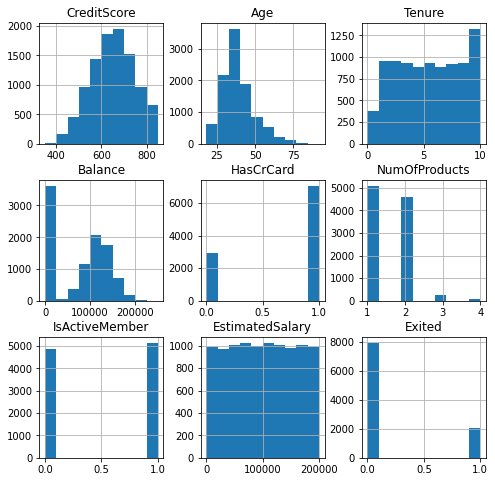

In [4]:
df[['CreditScore', 'Age', 'Tenure','Balance',  'HasCrCard','NumOfProducts','IsActiveMember',
   'EstimatedSalary', 'Exited']].hist(figsize=(8, 8));

In [5]:
df.query('Tenure.isna()')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [6]:
df.query('Exited == 0')['Tenure'].mean()

5.022246787342822

In [7]:
df.query('Exited == 1')['Tenure'].mean()

4.901833872707659

In [8]:
df['Tenure'].mean()

4.997690023099769

In [9]:
df['Tenure'].median()

5.0

### В строках с пропущенными значениями есть другая важная информация, поэтому пропущенные значения в столбце Tenure заполняем медианой. Значение медианы практически равно среднему, также эта величина одинаковая в группах ушедших из банка и оставшихся в банке.

In [10]:
df.loc[df['Tenure'].isna(), 'Tenure'] = df['Tenure'].median()
df['Tenure'].isna().sum()

0

#### Вывод: В таблице во всех столбцах, кроме Tenure нет пропусков, распределение данных в целом выглядят адекватно. Пропуски в столбце Tenure заменили на медианное значение. Удалять строки с пропусками нестала, т.к там моного другой важной информации. Ушедших клиентов немного по сравнению с оставшимися, т.е. есть наблюдается дисбаланс классов, более подробно изучим его далее.

### Создадим отдельную таблицу df_sername, в которой будет храниться уникальный идентификатор клиента и соответсвующая ему фамилия, предварительно проверив не повторняются ли уникальные номера в таблице. И удалим столбец Surname из df.

In [11]:
df['CustomerId'].value_counts()

15695872    1
15801062    1
15682268    1
15647453    1
15684319    1
           ..
15629677    1
15773039    1
15766896    1
15719793    1
15812607    1
Name: CustomerId, Length: 10000, dtype: int64

In [12]:
df_sername = df[['CustomerId','Surname']]
df = df.drop(['Surname'], axis=1)
print(df_sername.head())
df.head()

   CustomerId   Surname
0    15634602  Hargrave
1    15647311      Hill
2    15619304      Onio
3    15701354      Boni
4    15737888  Mitchell


,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Преобразовываем категориальные признаки в численные используя метод прямого кодирования One-Hot-Encodingm, чтобы не попасть в дамми-ловушку удаляем первый столбец (drop_first=True). Определяем размер датафрейма и выводим на экран первые 5 строк.

In [13]:
df = pd.get_dummies(df, drop_first=True)
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Разделяем исходные данные (df) на три выборки: обучающую (60%), валидационную (20%) и тестовую(20%) с помощью функции train_test_split из sklearn.model_selection¶

#### Разбиваем датасет df на два датасета features (датасет с признаками) и target (датасет со значениями целевого признака)

In [14]:
features = df.drop(['RowNumber', 'Exited', 'CustomerId'], axis=1)
print(features.info())
features.head()                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 654.4 KB
None


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


In [15]:
target = df['Exited']
target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

#### Разделяем исходные features и target сначала на две выборки: обучающую и выборку, которую будет потом делить на валидационную и тестовую

In [16]:
features_train, features_y, target_train, target_y = train_test_split(features, target, test_size=0.4, random_state=12345 )
print(features_train.shape)
target_train.shape

(6000, 11)


(6000,)

#### Разделяем выборки features_y и target_y на валидационную и тестовую

In [17]:
features_valid, features_test, target_valid, target_test = train_test_split(features_y, target_y, test_size=0.5, 
                                                                            random_state=12345 )
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
target_test.shape

(2000, 11)
(2000, 11)
(2000,)


(2000,)

### Производим масштабирование признаков с помощью StandardScaler 

In [18]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())
display(features_valid.head())
features_test.head()


/tmp/ipykernel_115/1091360682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_115/1091360682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,0.642466,-1.055187,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,-1.556504,-1.055187,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,-1.556504,0.947699,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,0.642466,-1.055187,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,-1.556504,-1.055187,1.524268,1,0,0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-1.101690,-1.233163,0.830152,0.642466,-1.055187,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.737696,-1.233163,-0.891560,0.642466,0.947699,1.471724,0,0,0
5511,0.151731,-0.657902,-1.829679,0.438711,-0.891560,0.642466,-1.055187,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.810266,1.239884,-0.891560,0.642466,0.947699,-0.786517,0,1,0
7367,-0.481743,0.291132,1.810266,-1.233163,0.830152,0.642466,-1.055187,1.358533,0,1,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-1.101690,-1.233163,0.830152,0.642466,-1.055187,0.647083,0,0,1
5709,-0.087120,0.006422,1.446272,-1.233163,-0.891560,0.642466,-1.055187,-1.658410,0,0,0
7117,-0.917905,-0.752805,-0.009707,0.722307,-0.891560,0.642466,0.947699,-1.369334,0,1,1
7775,-0.253277,0.101325,1.810266,-1.233163,0.830152,0.642466,-1.055187,0.075086,0,1,1
8735,0.785204,-0.847708,1.810266,0.615625,-0.891560,-1.556504,0.947699,-1.070919,0,0,1


#### Итог: Преобразовали категориальные признаки в численные, используя метод прямого кодирования One-Hot-Encodingm. Разделяем исходные данные (df) на три выборки: обучающую, валидационную и тестовую, предварительно выделив признаки и целевой признак. Провели масштабирование признаков.

## Исследование задачи

### Исследуем баланс классов, используя метод value_counts() к целевому признаку Exited таблицы df.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:title={'center':'class_frequency'}>

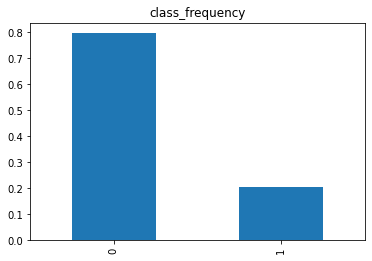

In [19]:
class_frequency = df['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar', title= 'class_frequency')


#### Вывод: наблюдается дисбаланс классов.

### Обучим модель "Логистическая регрессия" без учета дисбаланса классов и посчитаем значение F-1 меры.

In [20]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_train, predicted_train))
f1_score(target_valid, predicted_valid )

0.34378769601930037


0.33108108108108103

### Обучим модель "Решаюшее дерево" без учета дисбаланса классов и посчитаем значение F-1 меры.

In [21]:
best_model = None
best_result = 0
best_depth = 0
for depth in range (1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
            
f'F1_мера лучшей модели: {best_result},глубина дерева: {best_depth}' 


'F1_мера лучшей модели: 0.5696969696969697,глубина дерева: 6'

### Обучим модель "Случайного леса" без учета дисбаланса классов и посчитаем значение F-1 меры.

In [22]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in range (10,101,10):
    for depth in range (1,11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est
f'F1_мера лучшей модели: {best_result}, глубина дерева: {best_depth}, число деревьев {best_est}' 

'F1_мера лучшей модели: 0.5891238670694864, глубина дерева: 10, число деревьев 10'

#### Вывод: получили значение f1_меры 0,33 для логистической регрессии и 0,57 для решающего леса,  0.59 для случайного леса на валидационной выборке, модели предсказывают класс 1 плохо. Необходимо при обучении моделей учесть дисбаланс классов.

## Борьба с дисбалансом

### Попробуем при обучении моделей использовать "взвешивание классов". Обучим модели логистической регресии, решающего дерева и случайного леса.

#### Логистическая регрессия

In [23]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_valid = probabilities_valid[:,1]
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid))

F1-мера: 0.4888507718696398
AUC-ROC: 0.7636160997828441


#### Значение F1-меры стало больше, но оно не достаточное для выполнения задачи

#### Решающее дерево

In [24]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_min_samples_leaf = 0
best_auc_roc_tree = 0
for depth in range (1,11):
    for leaf in range (1,6):
        model_1 = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=2, min_samples_leaf=leaf,
                                         class_weight = 'balanced')
        model_1.fit(features_train, target_train)
        predictions = model_1.predict(features_valid)
        result = f1_score(target_valid, predictions)
        probabilities_valid_tree = model_1.predict_proba(features_valid)
        probabilities_valid_tree = probabilities_valid_tree[:,1]
        auc_roc_tree = roc_auc_score(target_valid, probabilities_valid_tree)
        if result > best_result_tree:
            best_model_tree = model_1
            best_result_tree = result
            best_depth_tree = depth
            best_min_samples_leaf = leaf
            best_auc_roc_tree = auc_roc_tree
f'F1_мера лучшей модели: {best_result_tree}, AUC-ROC лучшей модели:{best_auc_roc_tree}, глубина дерева: {best_depth_tree}, best_min_samples:{best_min_samples_leaf}' 

'F1_мера лучшей модели: 0.5987261146496814, AUC-ROC лучшей модели:0.8353985325340705, глубина дерева: 5, best_min_samples:2'

#### Значение F1-меры подходит, но может быть недостаточным при проверке на тестовой выборке. 

#### Случайный лес 

In [25]:
best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est = 0
best_auc_roc_forest = 0
for est in range (10,101,10):
    for depths in range (1,11):
        model_2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depths, class_weight = 'balanced')
        model_2.fit(features_train, target_train)
        predictions_forest = model_2.predict(features_valid)
        result_2 = f1_score(target_valid, predictions_forest)
        probabilities_valid_forest = model_2.predict_proba(features_valid)
        probabilities_valid_forest = probabilities_valid_forest[:,1]
        auc_roc_forest = roc_auc_score(target_valid, probabilities_valid_forest)
        if result_2 > best_result_forest:
            best_model_forest = model_2
            best_result_forest = result_2
            best_depth_forest = depths
            best_est = est
            best_auc_roc_forest = auc_roc_forest
f'F1_мера лучшей модели: {best_result_forest}, AUC-ROC лучшей модели:{best_auc_roc_forest}, глубина дерева: {best_depth_forest}, число деревьев {best_est}' 

'F1_мера лучшей модели: 0.6298850574712643, AUC-ROC лучшей модели:0.8554279907330675, глубина дерева: 9, число деревьев 90'

#### Значение F1-меры подходит, будем проверять данную модель на тестовой выборке

### Попробуем использовать технику upsampling при обучении моделей

#### Разделяем обучающую выборку на отрицательные и положительные ответы

In [26]:
features_zero = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zero = target_train[target_train == 0]
target_ones = target_train[target_train == 1]
print(target_zero.shape)
target_ones.shape

(4804,)


(1196,)

#### Преобразуем объекты положительного класса  и объеденим их с объектами отрицательного класса, используя функцию pd.concat()

In [27]:
repeat = 4
features_upsampled = pd.concat([features_zero] + [features_ones]*repeat)
target_upsampled = pd.concat([target_zero] + [target_ones]*repeat)
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
print(features_upsampled.shape)
print(target_upsampled.value_counts())
target_upsampled.shape


(9588, 11)
0    4804
1    4784
Name: Exited, dtype: int64


(9588,)

#### Обучаем модель логистической регресии на обучающей выборке features_upsampled

In [28]:
model_logistic = LogisticRegression(random_state=12345, solver='liblinear')
model_logistic.fit(features_upsampled, target_upsampled)
predicted_upsampled_logistic = model_logistic.predict(features_upsampled)
predicted_valid_logistic = model_logistic.predict(features_valid)
probabilities_valid = model_logistic.predict_proba(features_valid)
probabilities_valid = probabilities_valid[:,1]
print('F1-мера обучающая выборка:', f1_score(target_upsampled, predicted_upsampled_logistic))
print('F1-мера валидационная выборка:', f1_score(target_valid, predicted_valid))
print('AUC-ROC валидационная выборка:', roc_auc_score(target_valid, probabilities_valid))

F1-мера обучающая выборка: 0.7115970980969404
F1-мера валидационная выборка: 0.4888507718696398
AUC-ROC валидационная выборка: 0.76357526963023


#### Значение F1-меры  не достаточное для выполнения задачи

#### Обучаем модель решающее дерево на обучающей выборке features_upsampled

In [29]:
best_model_tree_up = None
best_depth_tree_up = 0
best_result_tree_up = 0
best_auc_roc_tree_up = 0 
for depth_up in range (1,11):
    model_tree_up =  DecisionTreeClassifier(random_state=12345, max_depth=depth_up, min_samples_split=2, min_samples_leaf=7)
    model_tree_up.fit(features_upsampled, target_upsampled)
    predicted_valid_tree_up = model_tree_up.predict(features_valid)
    result_tree_up = f1_score(target_valid, predicted_valid_tree_up)
    probabilities_valid_tree_up = model_tree_up.predict_proba(features_valid)
    probabilities_valid_tree_up = probabilities_valid_tree_up[:,1]
    auc_roc_tree_up = roc_auc_score(target_valid, probabilities_valid_tree_up)
    if result_tree_up > best_result_tree_up:
        best_model_tree_up = model_tree_up
        best_depth_tree_up = depth_up
        best_result_tree_up = result_tree_up
        best_auc_roc_tree_up = auc_roc_tree_up 
f'F1_мера лучшей модели: {best_result_tree_up}, AUC-ROC лучшей модели:{auc_roc_tree_up}, глубина дерева: {best_depth_tree_up}'         
        

'F1_мера лучшей модели: 0.5987261146496814, AUC-ROC лучшей модели:0.7824660202396578, глубина дерева: 5'

#### Значение F1-меры подходит, но может быть недостаточным при проверке на тестовой выборке. 

#### Обучаем модель случайный лес на обучающей выборке features_upsampled.  Сначала подбираем глубину дерева, потом количество деревьев.

In [30]:
best_model_forest_up = None
best_result_forest_up = 0
best_depth_forest_up = 0
for i in range (1,13):
    model_forest_up = RandomForestClassifier(random_state=12345,  max_depth=i, n_estimators=20)
    model_forest_up.fit(features_upsampled, target_upsampled)
    predictions_forest_up = model_forest_up.predict(features_valid)
    result_forest_up = f1_score(target_valid, predictions_forest_up)
    if  result_forest_up > best_result_forest_up:
        best_result_forest_up = result_forest_up
        best_model_forest_up = model_forest_up
        best_depth_forest_up = i
f'F1_мера лучшей модели: {best_result_forest_up}, глубина дерева: {best_depth_forest_up}'     
   
        
    

'F1_мера лучшей модели: 0.62217659137577, глубина дерева: 8'

In [31]:
model_forest_up = RandomForestClassifier(random_state=12345,  max_depth=8, n_estimators=30)
model_forest_up.fit(features_upsampled, target_upsampled)
predictions_forest_up = model_forest_up.predict(features_valid)
result_forest_up = f1_score(target_valid, predictions_forest_up)
probabilities_valid_forest_up = model_forest_up.predict_proba(features_valid)
probabilities_valid_forest_up = probabilities_valid_forest_up[:,1]
auc_roc_forest_up = roc_auc_score(target_valid, probabilities_valid_forest_up)
f'F1_мера валидационной выборки: {result_forest_up}, AUC-ROC валидационной выборки:{auc_roc_forest_up}'

'F1_мера валидационной выборки: 0.6239669421487604, AUC-ROC валидационной выборки:0.8528783745365022'

#### Значение F1-меры подходит, будем проверять данную модель на тестовой выборке¶

#### Итог: 
Для борьбы с дисбалансом классов были использованы две техники: взвешивание классов и upsampling. В каждой техники были обучены три вида моделей: логистическая регрессия, решающее дерево и случайный лес, также были замерены метрики качества каждой модели на валидационной выборке F1 - мера и AUC-ROC. По итогом обучения выбираем две модели с наилучшими показателями F1 - мера и AUC-ROC на валидационной выборке для дальнейшей проверки на тестовой выборке. Выбранные модели случайного леса:  best_model_forest (F1_мера : 0.6284403669724771, AUC-ROC: 0.8539475196438401),  model_forest_up (F1_мера : 0.6239669421487604, AUC-ROC :0.8528783745365022)

## Тестирование модели

### Тестируем модель "случайный лес", которую обучали на обучающей выборке, полученной с использованием техники upsamplin, на тестовой выборке. 

In [32]:
%%time

predictions_forest_up_test = model_forest_up.predict(features_test)
result_forest_up_test = f1_score(target_test, predictions_forest_up_test)
probabilities_valid_forest_up_test = model_forest_up.predict_proba(features_test)
probabilities_valid_forest_up_test = probabilities_valid_forest_up_test[:,1]
auc_roc_forest_up_test = roc_auc_score(target_test, probabilities_valid_forest_up_test)
print('Полнота:', recall_score(target_test, predictions_forest_up_test))
f'F1_мера тестовой выборки: {result_forest_up_test}, AUC-ROC тестовой выборки:{auc_roc_forest_up_test}'

Полнота: 0.7257683215130024
CPU times: user 28.3 ms, sys: 8 ms, total: 36.3 ms
Wall time: 41.3 ms


'F1_мера тестовой выборки: 0.6133866133866135, AUC-ROC тестовой выборки:0.8555985794615567'

### Тестируем модель "случайный лес", которую обучали c  учетом "взвешивание классов"

In [33]:
%%time

predictions_forest_test = best_model_forest.predict(features_test)
result_forest_test = f1_score(target_test, predictions_forest_test)
probabilities_valid_forest_test = best_model_forest.predict_proba(features_test)
probabilities_valid_forest_test = probabilities_valid_forest_test[:,1]
auc_roc_forest_up_test = roc_auc_score(target_test, probabilities_valid_forest_test)
print('Полнота:', recall_score(target_test, predictions_forest_test))
f'F1_мера тестовой выборки: {result_forest_test}, AUC-ROC тестовой выборки:{auc_roc_forest_up_test}'

Полнота: 0.6359338061465721
CPU times: user 81.5 ms, sys: 0 ns, total: 81.5 ms
Wall time: 90.6 ms


'F1_мера тестовой выборки: 0.6106696935300795, AUC-ROC тестовой выборки:0.8561187639696525'

### Проверим модели на адекватность, сравних их с константной моделью.

In [34]:
from sklearn.dummy import DummyClassifier

model_const = DummyClassifier(strategy="constant", constant=1)
model_const.fit(features_train, target_train)
f1_score(target_test, model_const.predict(features_test))

0.3491539413949649

Обе модели адекватные, т.к. значение f1 константной модели значительно хуже.

#### Проверив результаты работы моделей на тестовой выборке, получили следующие результаты:
Качество работы модели "Случайный лес", которую обучали c учетом "взвешивания классов" чуть ниже,чем качество работы модели
"Случайный лес", которую обучали на обучающей выборке, полученной с использованием техники upsamplin, F1_мера - 0.610 и 
0.613 соответсвенно. Поэтому вибираем модель "Случайный лес", котрую обучали на обучающей выборке, полученной с 
использованием техники upsamplin. AUC-ROC данной модели также выше и составляет 0.856 против 0.855.

## Итоговый вывод
1. Изучив данные о клиентах банка увидели, чтьо во всех столбцах кроме Tenure нет пропусков, распределение значений в столбцах выглядит логичным. Пропуски в столбце Tenure заменили на медианное значение. Ушедших клиентов немного по сравнению с ставшимися, т.е. есть наблюдается дисбаланс классов.
2. Преобразовали категориальные признаки в численные, используя метод прямого кодирования One-Hot-Encodingm. Разделили исходные данные (df) на три выборки: обучающую, валидационную и тестовую, предварительно выделив признаки и целевой признак. Провели масштабирование признаков.
3. Для борьбы с дисбалансом классов были использованы две техники: взвешивание классов и upsampling. В каждой техники были обучены три вида моделей: логистическая регрессия, решающее дерево и случайный лес, также были замерены метрики качества каждой модели на валидационной выборке F1 - мера и AUC-ROC. По итогом обучения выбрали две модели с наилучшими показателями F1 - мера и AUC-ROC на валидационной выборке для дальнейшей проверки на тестовой выборке. Выбранные модели случайного леса: best_model_forest (F1_мера : 0.6284403669724771, AUC-ROC: 0.8539475196438401), model_forest_up (F1_мера : 0.6239669421487604, AUC-ROC :0.8528783745365022)
4. Проверив результаты работы моделей на тестовой выборке, получили следующие результаты:
Качество работы модели "Случайный лес", которую обучали c учетом "взвешивания классов" чуть ниже, чем качество работы модели "Случайный лес", которую обучали на обучающей выборке, полученной с использованием техники upsamplin, F1_мера - 0.610 и 0.613 соответсвенно. Поэтому вибираем модель "Случайный лес", котрую обучали на обучающей выборке, полученной с использованием техники upsamplin. AUC-ROC данной модели также выше и составляет 0.856 против 0.855.